# Image Colorization with Bin Classification
- Each pixel assigned to one bin
- Cross-entropy loss
- Direct bin center lookup for decoding


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt

import os
from pathlib import Path
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

In [ ]:
class SimpleColorBinning:
    def __init__(self, bin_size=10):
        self.bin_size = bin_size

        # Generate AB bin centers
        self.bin_centers = self._generate_bin_centers()
        self.num_bins = len(self.bin_centers)

        # Fit nearest neighbors for fast lookup (k=1 for hard classification)
        self.nn_model = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
        self.nn_model.fit(self.bin_centers)

        print(f"Initialized with {self.num_bins} bins")

    def _generate_bin_centers(self):
        """
        Generate 313 in-gamut AB bin centers.
        AB range is [-110, 110] for valid colors.
        """
        a_range = np.arange(-110, 110, self.bin_size)
        b_range = np.arange(-110, 110, self.bin_size)

        bins = []
        for a in a_range:
            for b in b_range:
                # Check if color is in-gamut by testing with a mid-range L value
                lab = np.array([[[50, a, b]]], dtype=np.float64)
                try:
                    rgb = color.lab2rgb(lab)
                    # Valid if RGB values are in [0, 1]
                    if np.all(rgb >= 0) and np.all(rgb <= 1):
                        bins.append([a, b])
                except:
                    continue

        return np.array(bins)

    def ab_to_bin_indices(self, ab_values):
        """
        Convert AB values to hard bin indices.

        Args:
            ab_values: (H, W, 2) array of AB values in range [-128, 128]

        Returns:
            bin_indices: (H, W) array of bin indices
        """
        H, W = ab_values.shape[:2]
        ab_flat = ab_values.reshape(-1, 2)

        # Find nearest bin for each pixel
        _, indices = self.nn_model.kneighbors(ab_flat)

        return indices.reshape(H, W).squeeze()

    def bins_to_ab(self, bin_indices):
        """
        Args:
            bin_indices: (H, W) array of bin indices

        Returns:
            ab_values: (H, W, 2) array of AB values
        """
        return self.bin_centers[bin_indices]

    def get_class_weights(self, dataset, num_samples=10000):
        """
        Calculate class weights to handle imbalanced colors.

        Args:
            dataset: Dataset to compute weights from
            num_samples: Number of samples to use

        Returns:
            weights: (num_bins,) array of class weights
        """
        bin_counts = np.zeros(self.num_bins)
        sample_indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)

        for idx in tqdm(sample_indices, desc='Computing weights'):
            _, bin_idx = dataset[idx]
            bin_idx_np = bin_idx.numpy()

            # Count each bin occurrence
            unique, counts = np.unique(bin_idx_np, return_counts=True)
            bin_counts[unique] += counts

        # Inverse frequency weighting with smoothing
        bin_prior = bin_counts / bin_counts.sum()
        lambda_val = 0.5
        uniform_prior = 1.0 / self.num_bins
        smoothed_prior = lambda_val * uniform_prior + (1 - lambda_val) * bin_prior

        weights = 1.0 / (smoothed_prior + 1e-8)
        weights = weights / (np.sum(weights * bin_prior))

        return weights

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, split='train', img_size=512, color_binning=None):
        """
        Args:
            root_dir: Root directory containing train/test subdirectories
            split: 'train' or 'test'
            img_size: Size to resize images to
            color_binning: SimpleColorBinning instance
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.img_size = img_size
        self.color_binning = color_binning

        # Get image paths
        img_dir = self.root_dir / split
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.JPEG', '.JPG', '.PNG')
        self.image_paths = [p for p in img_dir.iterdir() if p.suffix in valid_extensions]

        print(f"Found {len(self.image_paths)} images in {img_dir}")

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and transform image
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img_rgb = self.transform(img).numpy().transpose(1, 2, 0)  # (H, W, 3)

        # Convert to LAB
        img_lab = color.rgb2lab(img_rgb)

        # Extract L channel (normalize to [0, 1])
        L = img_lab[:, :, 0] / 100.0
        L = torch.FloatTensor(L).unsqueeze(0)  # (1, H, W)

        # Extract AB channels and convert to bin indices
        AB = img_lab[:, :, 1:]  # (H, W, 2), range [-128, 128]

        if self.color_binning is not None:
            # Convert to hard bin indices
            bin_indices = self.color_binning.ab_to_bin_indices(AB)
            bin_indices = torch.LongTensor(bin_indices)  # (H, W)
            return L, bin_indices
        else:
            # Fallback: return normalized AB
            AB_normalized = AB / 128.0
            AB_normalized = torch.FloatTensor(AB_normalized).permute(2, 0, 1)
            return L, AB_normalized

In [ ]:
class ConvBlock(nn.Module):
    """convolutional block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class ColorizationUNet(nn.Module):
    """
    U-Net architecture for colorization.
    Outputs classification logits over 313 bins.
    """

    def __init__(self, num_bins=313):
        super().__init__()
        self.num_bins = num_bins

        # Encoder
        self.enc1 = ConvBlock(1, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)

        self.pool = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 512)

        # Decoder
        self.up4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4 = ConvBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        # Output layer
        self.final = nn.Conv2d(64, num_bins, 1)

    def forward(self, x):
        # Encoder with skip connections
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder with skip connections
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        # Output
        out = self.final(d1)

        return out

In [ ]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights=None):
        super().__init__()
        self.class_weights = class_weights

        if class_weights is not None:
            self.class_weights = class_weights / class_weights.mean()

    def forward(self, pred_logits, target_bins):
        """
        Args:
            pred_logits: (B, Q, H, W) predicted logits over bins
            target_bins: (B, H, W) ground truth bin indices [LongTensor]

        Returns:
            loss: Scalar loss value
        """
        B, Q, H, W = pred_logits.shape

        # Reshape for cross-entropy
        pred_logits = pred_logits.permute(0, 2, 3, 1).reshape(-1, Q)  # (B*H*W, Q)
        target_bins = target_bins.reshape(-1)  # (B*H*W,)

        # Standard cross-entropy loss
        if self.class_weights is not None:
            weight = self.class_weights.to(pred_logits.device)
            loss = F.cross_entropy(pred_logits, target_bins, weight=weight)
        else:
            loss = F.cross_entropy(pred_logits, target_bins)

        return loss

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    pbar = tqdm(loader, desc='Training')
    for L, target_bins in pbar:
        L = L.to(device)
        target_bins = target_bins.to(device)

        # Forward pass
        pred_logits = model(L)
        loss = criterion(pred_logits, target_bins)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader)


def validate(model, loader, criterion, device, color_binning, num_viz_samples=0):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    viz_samples = [] if num_viz_samples > 0 else None

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for batch_idx, (L, target_bins) in enumerate(pbar):
            L = L.to(device)
            target_bins = target_bins.to(device)

            # Forward pass
            pred_logits = model(L)
            loss = criterion(pred_logits, target_bins)

            # Calculate accuracy
            pred_bins = torch.argmax(pred_logits, dim=1)  # (B, H, W)
            correct += (pred_bins == target_bins).sum().item()
            total += target_bins.numel()

            total_loss += loss.item()
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * correct / total:.2f}%'
            })

            # Collect samples for visualization
            if viz_samples is not None and len(viz_samples) < num_viz_samples:
                for i in range(min(L.shape[0], num_viz_samples - len(viz_samples))):
                    # Get single sample
                    L_sample = L[i].cpu().numpy().squeeze()  # (H, W)
                    pred_bin_sample = pred_bins[i].cpu().numpy()  # (H, W)
                    target_bin_sample = target_bins[i].cpu().numpy()  # (H, W)

                    # Convert bins to AB (simple lookup)
                    pred_ab = color_binning.bins_to_ab(pred_bin_sample)
                    target_ab = color_binning.bins_to_ab(target_bin_sample)

                    viz_samples.append({
                        'L': L_sample,
                        'pred_ab': pred_ab,
                        'target_ab': target_ab
                    })

    avg_loss = total_loss / len(loader)
    accuracy = 100.0 * correct / total

    print(f"\nValidation Accuracy: {accuracy:.2f}%")

    return avg_loss, viz_samples


def visualize_results(samples, save_path=None):
    n = len(samples)
    fig, axes = plt.subplots(n, 3, figsize=(15, 5*n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for i, sample in enumerate(samples):
        L = sample['L']
        pred_ab = sample['pred_ab']
        target_ab = sample['target_ab']

        # Denormalize L
        L_denorm = L * 100.0

        # Create LAB images
        lab_gray = np.stack([L_denorm, np.zeros_like(L_denorm), np.zeros_like(L_denorm)], axis=2)
        lab_pred = np.concatenate([L_denorm[:, :, np.newaxis], pred_ab], axis=2)
        lab_target = np.concatenate([L_denorm[:, :, np.newaxis], target_ab], axis=2)

        # Convert to RGB
        rgb_gray = color.lab2rgb(lab_gray)
        rgb_pred = color.lab2rgb(lab_pred)
        rgb_target = color.lab2rgb(lab_target)

        # Plot
        axes[i, 0].imshow(rgb_gray)
        axes[i, 0].set_title('Grayscale Input', fontsize=14)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.clip(rgb_pred, 0, 1))
        axes[i, 1].set_title('Predicted (Simple Classification)', fontsize=14)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(np.clip(rgb_target, 0, 1))
        axes[i, 2].set_title('Ground Truth', fontsize=14)
        axes[i, 2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")

    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Using device: cuda

Initializing simple color binning...
Initialized SimpleColorBinning with 225 bins

Loading datasets...
Found 5882 images in /content/drive/MyDrive/ProjectDL/dataset/train
Found 1037 images in /content/drive/MyDrive/ProjectDL/dataset/test
Computing class weights from 2500 samples...


Computing weights: 100%|██████████| 2500/2500 [04:42<00:00,  8.86it/s]



Initializing model...
Total parameters: 20,568,097

Starting training...

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [05:04<00:00,  2.34s/it, loss=3.6368, acc=20.43%]



Validation Accuracy: 20.43%

Epoch 1 Summary:
  Train Loss: 4.4284
  Val Loss: 3.8735
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.8735)
Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [00:51<00:00,  2.51it/s, loss=3.2082, acc=21.99%]



Validation Accuracy: 21.99%

Epoch 2 Summary:
  Train Loss: 3.7660
  Val Loss: 3.6134
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.6134)
Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [00:51<00:00,  2.51it/s, loss=3.3893, acc=21.79%]



Validation Accuracy: 21.79%

Epoch 3 Summary:
  Train Loss: 3.6255
  Val Loss: 3.5628
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.5628)
Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [00:51<00:00,  2.51it/s, loss=3.0446, acc=17.17%]



Validation Accuracy: 17.17%

Epoch 4 Summary:
  Train Loss: 3.5491
  Val Loss: 3.4725
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.4725)
Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [00:51<00:00,  2.52it/s, loss=3.0005, acc=19.64%]



Validation Accuracy: 19.64%

Epoch 5 Summary:
  Train Loss: 3.5138
  Val Loss: 3.4525
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.4525)
Saved visualization to /content/drive/MyDrive/ProjectDL/experiments_simple/viz_epoch_5.png


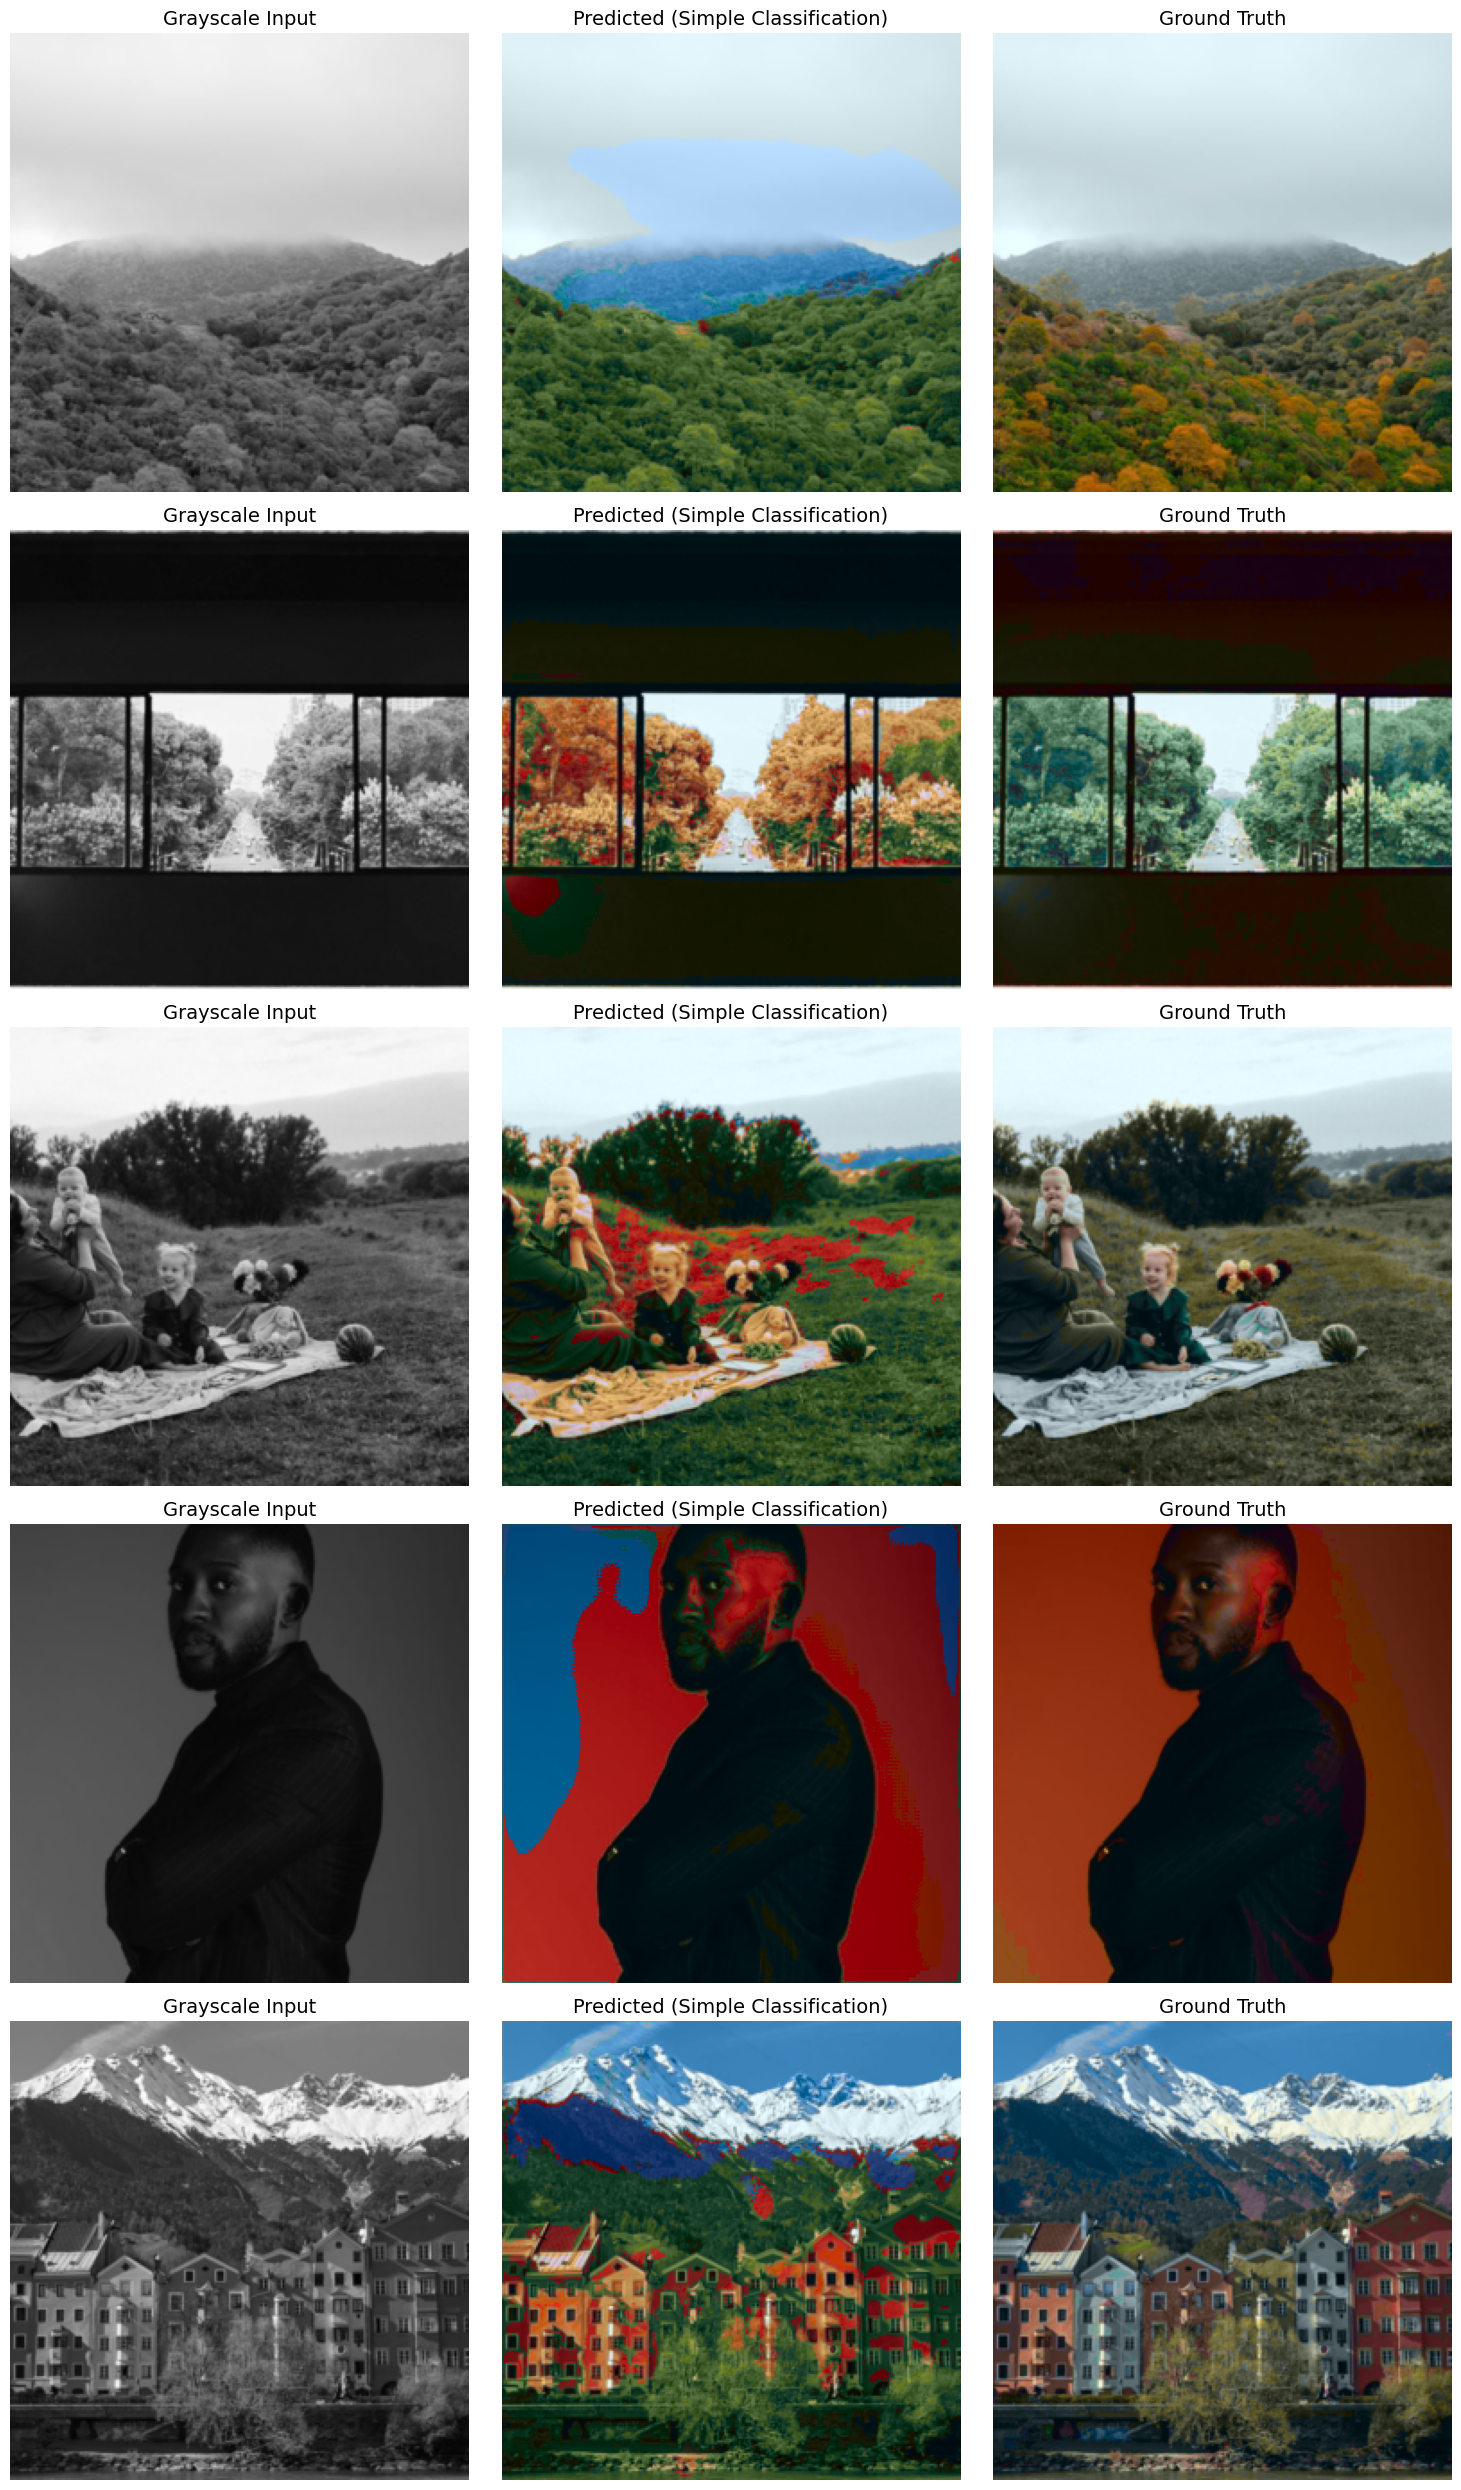

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [00:51<00:00,  2.51it/s, loss=3.1657, acc=20.31%]



Validation Accuracy: 20.31%

Epoch 6 Summary:
  Train Loss: 3.4821
  Val Loss: 3.3878
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.3878)
Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [00:51<00:00,  2.51it/s, loss=3.1421, acc=21.08%]



Validation Accuracy: 21.08%

Epoch 7 Summary:
  Train Loss: 3.4528
  Val Loss: 3.3591
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.3591)
Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [00:52<00:00,  2.50it/s, loss=3.0622, acc=20.12%]



Validation Accuracy: 20.12%

Epoch 8 Summary:
  Train Loss: 3.4346
  Val Loss: 3.3502
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.3502)
Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [00:51<00:00,  2.51it/s, loss=3.1449, acc=20.72%]



Validation Accuracy: 20.72%

Epoch 9 Summary:
  Train Loss: 3.4342
  Val Loss: 3.3459
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.3459)
Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 130/130 [00:51<00:00,  2.51it/s, loss=3.0074, acc=20.81%]



Validation Accuracy: 20.81%

Epoch 10 Summary:
  Train Loss: 3.4126
  Val Loss: 3.3290
  Learning Rate: 1.00e-04

  → Saved best model (val_loss: 3.3290)
Saved visualization to /content/drive/MyDrive/ProjectDL/experiments_simple/viz_epoch_10.png


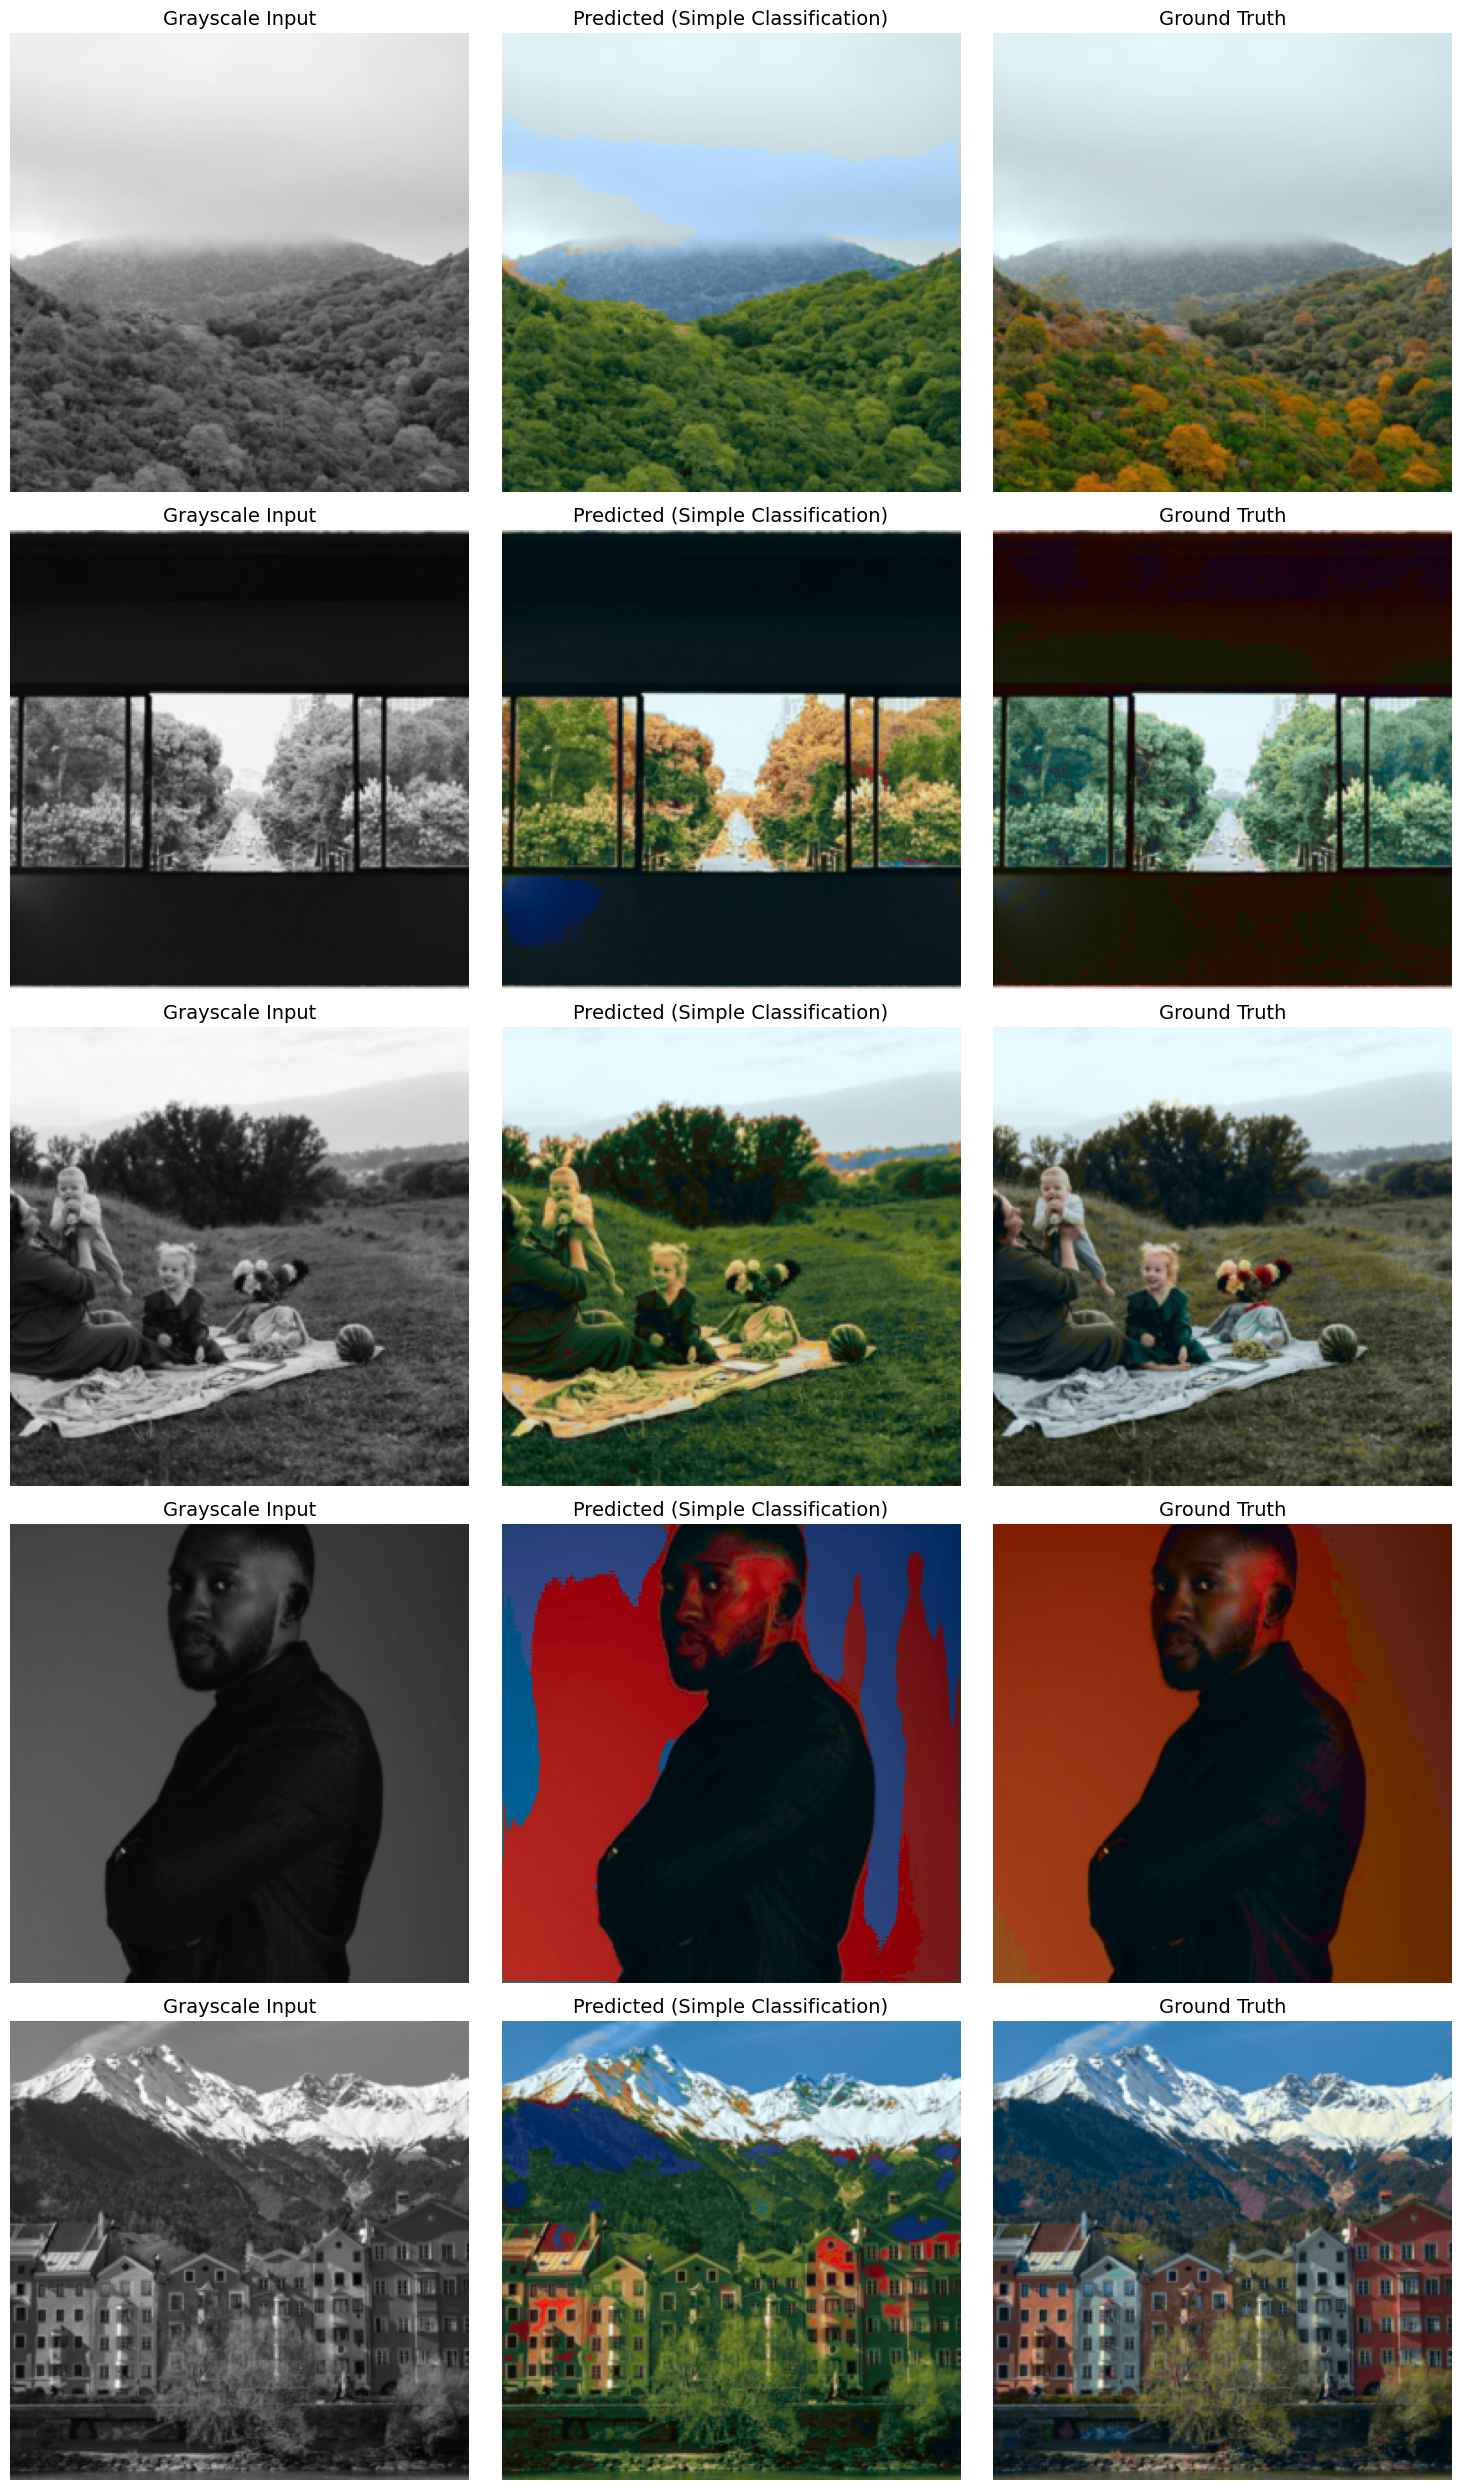

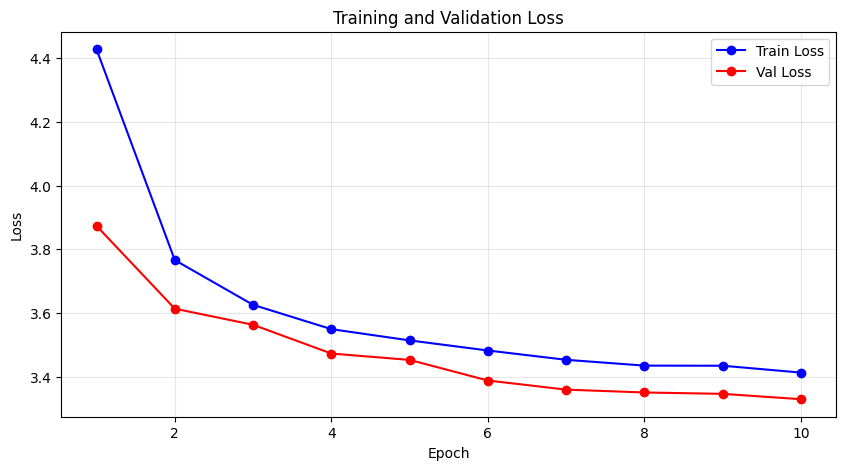


Training complete!
Best validation loss: 3.3290


In [ ]:
def main():
    # Hyperparameters
    config = {
        'img_size': 256,
        'batch_size': 8,
        'num_epochs': 10,
        'learning_rate': 1e-4,
        'num_workers': 2,
        'data_root': '/content/drive/MyDrive/ProjectDL/dataset',
        'save_dir': '/content/drive/MyDrive/ProjectDL/experiments_simple',
        'bin_size': 15,
    }

    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    os.makedirs(config['save_dir'], exist_ok=True)

    # Initialize simple color binning (no k-NN, no soft encoding)
    print('\nInitializing simple color binning...')
    color_binning = SimpleColorBinning(bin_size=config['bin_size'])

    # Create datasets
    print('\nLoading datasets...')
    train_dataset = ColorizationDataset(
        config['data_root'],
        split='train',
        img_size=config['img_size'],
        color_binning=color_binning
    )
    val_dataset = ColorizationDataset(
        config['data_root'],
        split='test',
        img_size=config['img_size'],
        color_binning=color_binning
    )

    # Compute class weights
    class_weights = color_binning.get_class_weights(train_dataset, num_samples=2500)
    class_weights_tensor = torch.FloatTensor(class_weights)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True
    )

    # Create model
    print('\nInitializing model...')
    model = ColorizationUNet(num_bins=color_binning.num_bins).to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total parameters: {total_params:,}')

    # Loss and optimizer
    criterion = WeightedCrossEntropyLoss(class_weights=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-7
    )

    # Training loop
    print('\nStarting training...\n')
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(config['num_epochs']):
        print(f'Epoch {epoch+1}/{config["num_epochs"]}')
        print('-' * 50)

        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validate (with visualization every 5 epochs)
        num_viz = 5 if (epoch + 1) % 5 == 0 else 0
        val_loss, viz_samples = validate(
            model, val_loader, criterion, device, color_binning, num_viz_samples=num_viz
        )
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        print(f'\nEpoch {epoch+1} Summary:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')
        print(f'  Learning Rate: {current_lr:.2e}\n')

        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': config,
            'color_binning_params': {
                'bin_centers': color_binning.bin_centers,
                'num_bins': color_binning.num_bins,
            }
        }

        save_path = os.path.join(config['save_dir'], f'checkpoint_epoch_{epoch+1}.pth')
        torch.save(checkpoint, save_path)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_path = os.path.join(config['save_dir'], 'best_model.pth')
            torch.save(checkpoint, best_path)
            print(f'  → Saved best model (val_loss: {val_loss:.4f})')

        # Visualize results
        if viz_samples:
            viz_path = os.path.join(config['save_dir'], f'viz_epoch_{epoch+1}.png')
            visualize_results(viz_samples, save_path=viz_path)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, config['num_epochs']+1), train_losses, 'b-', label='Train Loss', marker='o')
    plt.plot(range(1, config['num_epochs']+1), val_losses, 'r-', label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(config['save_dir'], 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print('\nTraining complete!')
    print(f'Best validation loss: {best_val_loss:.4f}')


if __name__ == '__main__':
    main()

Initialized SimpleColorBinning with 225 bins
Loaded best model from epoch 10
Best validation loss: 3.3290

Found 1037 images in /content/drive/MyDrive/ProjectDL/dataset/test
Computing PSNR on test set...


Evaluating PSNR: 100%|██████████| 130/130 [00:56<00:00,  2.29it/s]



PSNR Evaluation Results:
Average PSNR: 18.20 dB
Std Dev:      3.15 dB
Min PSNR:     6.67 dB
Max PSNR:     37.03 dB
Median PSNR:  18.36 dB



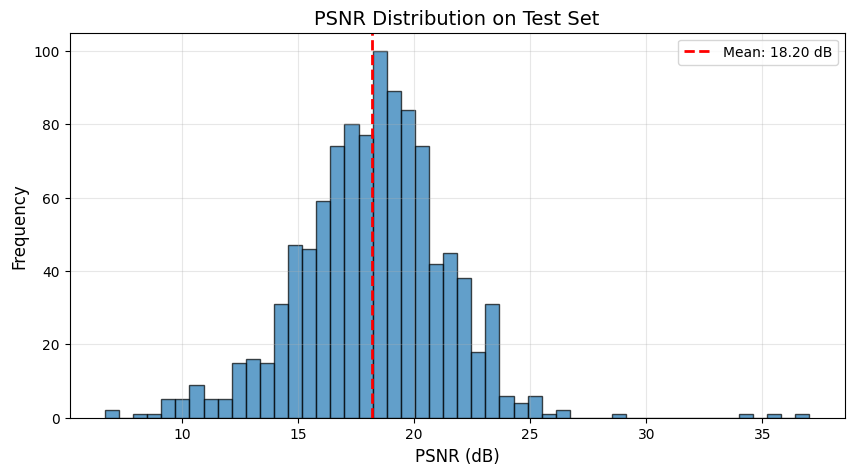

In [ ]:
# ============================================================================
# PSNR EVALUATION CELL
# ============================================================================

import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import color

def evaluate_psnr(model, loader, color_binning, device):
    """
    Evaluate PSNR on a dataset.

    Returns:
        avg_psnr: Average PSNR across all images
        psnr_list: List of PSNR values for each image
    """
    model.eval()
    psnr_list = []

    print("Computing PSNR on test set...")


    with torch.no_grad():
        for L, target_bins in tqdm(loader, desc='Evaluating PSNR'):
            L = L.to(device)
            target_bins = target_bins.to(device)

            # Predict
            pred_logits = model(L)
            pred_bins = torch.argmax(pred_logits, dim=1)  # (B, H, W)

            # Process each image in batch
            for i in range(L.shape[0]):
                L_sample = L[i].cpu().numpy().squeeze()  # (H, W)
                pred_bin_sample = pred_bins[i].cpu().numpy()  # (H, W)
                target_bin_sample = target_bins[i].cpu().numpy()  # (H, W)

                # Convert to AB values
                pred_ab = color_binning.bins_to_ab(pred_bin_sample)
                target_ab = color_binning.bins_to_ab(target_bin_sample)

                # Denormalize L
                L_denorm = L_sample * 100.0

                # Create LAB images
                lab_pred = np.concatenate([L_denorm[:, :, np.newaxis], pred_ab], axis=2)
                lab_target = np.concatenate([L_denorm[:, :, np.newaxis], target_ab], axis=2)

                # Convert to RGB
                rgb_pred = color.lab2rgb(lab_pred)
                rgb_target = color.lab2rgb(lab_target)

                # Clip to valid range
                rgb_pred = np.clip(rgb_pred, 0, 1)
                rgb_target = np.clip(rgb_target, 0, 1)

                # Calculate PSNR
                psnr_value = psnr(rgb_target, rgb_pred, data_range=1.0)
                psnr_list.append(psnr_value)

    avg_psnr = np.mean(psnr_list)
    std_psnr = np.std(psnr_list)

    return avg_psnr, std_psnr, psnr_list


# ============================================================================
# RUN EVALUATION
# ============================================================================
config = {
    'img_size': 256,
    'batch_size': 8,
    'num_epochs': 10,
    'learning_rate': 1e-4,
    'num_workers': 2,
    'data_root': '/content/drive/MyDrive/ProjectDL/dataset',
    'save_dir': '/content/drive/MyDrive/ProjectDL/experiments_simple',
    'bin_size': 15,
}
# Load best model
checkpoint_path = os.path.join(config['save_dir'], 'best_model.pth')
checkpoint = torch.load(checkpoint_path, map_location='cuda', weights_only=False)
color_binning = SimpleColorBinning(bin_size=config['bin_size'])
model = ColorizationUNet(num_bins=color_binning.num_bins).to('cuda')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation loss: {checkpoint['val_loss']:.4f}\n")

val_dataset = ColorizationDataset(
        config['data_root'],
        split='test',
        img_size=config['img_size'],
        color_binning=color_binning
    )

val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True
    )
# Evaluate PSNR
avg_psnr, std_psnr, psnr_list = evaluate_psnr(model, val_loader, color_binning, 'cuda')

print(f"\n{'='*60}")
print(f"PSNR Evaluation Results:")
print(f"{'='*60}")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Std Dev:      {std_psnr:.2f} dB")
print(f"Min PSNR:     {np.min(psnr_list):.2f} dB")
print(f"Max PSNR:     {np.max(psnr_list):.2f} dB")
print(f"Median PSNR:  {np.median(psnr_list):.2f} dB")
print(f"{'='*60}\n")

# Plot PSNR distribution
plt.figure(figsize=(10, 5))
plt.hist(psnr_list, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(avg_psnr, color='r', linestyle='--', linewidth=2, label=f'Mean: {avg_psnr:.2f} dB')
plt.xlabel('PSNR (dB)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('PSNR Distribution on Test Set', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(config['save_dir'], 'psnr_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# INFERENCE SCRIPT
# ============================================================================

def load_model_and_colorize(checkpoint_path, test_image_path, output_path=None):
    """
    Load a trained model and colorize a test image.

    Args:
        checkpoint_path: Path to model checkpoint
        test_image_path: Path to grayscale or color image to colorize
        output_path: Optional path to save colorized image
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load checkpoint
    print('Loading checkpoint...')
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Recreate color binning
    bin_params = checkpoint['color_binning_params']
    color_binning = SimpleColorBinning()
    color_binning.bin_centers = bin_params['bin_centers']
    color_binning.num_bins = bin_params['num_bins']
    color_binning.nn_model = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    color_binning.nn_model.fit(color_binning.bin_centers)

    # Create model
    model = ColorizationUNet(num_bins=color_binning.num_bins).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"Loaded model from epoch {checkpoint['epoch']+1}")

    # Load and preprocess image
    img = Image.open(test_image_path).convert('RGB')
    original_size = img.size

    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    img_rgb = transform(img).numpy().transpose(1, 2, 0)
    img_lab = color.rgb2lab(img_rgb)
    L = img_lab[:, :, 0] / 100.0
    L_tensor = torch.FloatTensor(L).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)

    # Predict
    print('Colorizing...')
    with torch.no_grad():
        pred_logits = model(L_tensor)
        pred_bins = torch.argmax(pred_logits, dim=1).cpu().numpy()[0]  # (H, W)

    # Convert to AB (simple lookup - no annealed-mean!)
    pred_ab = color_binning.bins_to_ab(pred_bins)

    # Create colorized image
    L_denorm = L * 100.0
    lab_colorized = np.concatenate([L_denorm[:, :, np.newaxis], pred_ab], axis=2)
    rgb_colorized = color.lab2rgb(lab_colorized)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(color.lab2rgb(np.stack([L_denorm, np.zeros_like(L_denorm), np.zeros_like(L_denorm)], axis=2)))
    axes[0].set_title('Grayscale Input')
    axes[0].axis('off')

    axes[1].imshow(np.clip(rgb_colorized, 0, 1))
    axes[1].set_title('Colorized Output (Simple Classification)')
    axes[1].axis('off')

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f'Saved result to {output_path}')

    plt.show()

    return rgb_colorized


# Example usage:
colorized = load_model_and_colorize(
     checkpoint_path='/content/drive/MyDrive/ProjectDL/experiments_simple/best_model.pth',
     test_image_path='/path/to/test_image.jpg',
     output_path='/path/to/output.png'
 )